In [1]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib widget

In [2]:
ker = SourceModule("""
#define _X      (threadIdx.x + blockIdx.x * blockDim.x)
#define _Y      (threadIdx.y + blockIdx.y * blockDim.y)

#define _WIDTH  (blockDim.x * gridDim.x)
#define _HEIGHT (blockDim.y * gridDim.y)

#define _XM(x)  ((x + _WIDTH) % _WIDTH)
#define _YM(y)  ((y + _HEIGHT) % _HEIGHT)

#define _INDEX(x, y) (_XM(x) + _YM(y) * _WIDTH)

__device__ int nbrs(int x, int y, int *in) {
    return in[_INDEX(x-1, y+1)] + in[_INDEX(x-1, y)] \
        + in[_INDEX(x-1, y-1)] + in[_INDEX(x, y+1)] \
        + in[_INDEX(x, y-1)] + in[_INDEX(x+1, y-1)] \
        + in[_INDEX(x+1, y)] + in[_INDEX(x+1, y+1)];
}

__global__ void conway_ker(int *lattice_out, int *lattice) {
    int x = _X, y = _Y;

    int n = nbrs(x, y, lattice);

    if (lattice[_INDEX(x, y)] == 1) {
        switch (n) {
            case 2:
            case 3: lattice_out[_INDEX(x, y)] = 1;
                    break;
            default: lattice_out[_INDEX(x, y)] = 0;
        }
    } else if (lattice[_INDEX(x, y)] == 0) {
        switch (n) {
            case 3: lattice_out[_INDEX(x, y)] = 1;
                    break;
            default: lattice_out[_INDEX(x, y)] = 0;
        }
    }
}

""")

conway_ker = ker.get_function("conway_ker")


In [3]:
def update_gpu(frameNum, img, new_lattice_gpu, lattice_gpu, N):
    conway_ker(new_lattice_gpu, lattice_gpu,
               grid=(N//32, N//32, 1), block=(32, 32, 1))
    img.set_data(new_lattice_gpu.get())
    lattice_gpu[:] = new_lattice_gpu[:]

    return img


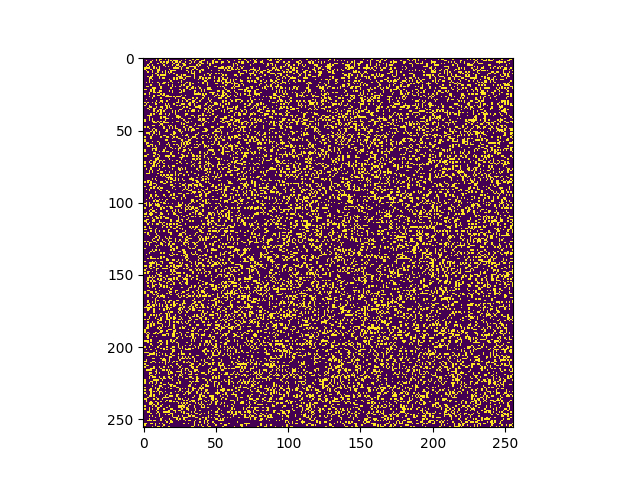

In [4]:

N = 256
lattice = np.random.choice([1, 0], N * N, p=[0.25, 0.75])\
    .reshape(N, N).astype(np.int32)
lattice_gpu = gpuarray.to_gpu(lattice)
new_lattice_gpu = gpuarray.empty_like(lattice_gpu)

fig, ax = plt.subplots()
image = ax.imshow(lattice_gpu.get(), interpolation='nearest')
ani = animation.FuncAnimation(fig, update_gpu,
    fargs=(image, new_lattice_gpu, lattice_gpu, N,),
    interval=10, frames=1000, save_count=1000)

plt.show()